In [1]:
from dataset import dataset, Encoder, Collate
from model import CRNNModel
import transform

import torch
from torch.utils.data import DataLoader
import albumentations as A
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['image.cmap'] = 'gray'

In [8]:
_, _, testset = dataset('IAM', '/mnt/d/Machine-Learning/Datasets/iamdataset/uncompressed',
                                    csv_file_path='IAM_df.csv', default_partition=False, partition=(0.7, 0.1, 0.2), shuffle=False, seed=42)

In [9]:
print(len(testset))
testset.data.head()

2670


,Image,Segmentation,Transcription,Threshold
0,l07-135-08,err,the river and in and out of the other boats.,175
1,l07-138-00,ok,"It was a warm, still evening; the plop of",181
2,l07-138-01,ok,fish and the gentle putter of the engine,185
3,l07-138-02,ok,"were infinitely soothing after city noises,",183
4,l07-138-03,ok,and I began to look forward to my life,185


In [31]:
encoder = Encoder(testset.charset)
collater = Collate(encoder)

test_loader = DataLoader(testset,
    batch_size=16,
    shuffle=True, 
    collate_fn=collater,
    num_workers=0
)

test_batch = next(iter(test_loader))
images, targets, target_lengths, ground_truth = test_batch

In [21]:
model = CRNNModel(vocab_size=79, time_steps=100)

device = torch.device('cpu')
checkpoint = torch.load(
    'checkpoints/training_state.pth', map_location=device)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [32]:
dev = 'cpu'

with torch.no_grad():

    model.to(dev)
    images = images.to(dev)
    targets = targets.to(dev)
    target_lengths = target_lengths.to(dev)

    preds = model(images)
    preds_decoded = encoder.best_path_decode(
        preds, return_text=True)

In [33]:
ground_truth

('(literally) all-powerful Rocket Release',
 'had more clothes on."',
 'Time passed. Everyone said, "Pity about Megan',
 'turned the tuning knob through all the',
 'A bully like that respects anyone who',
 'speed to the Villa, it was quickly evident that',
 'said, meaning it. He pressed the tip of my',
 'which had followed her slim young figure',
 'I would be moving in.',
 'solar system. True enough, such ultimate weapons had not been',
 'a muffled bell taps the sky. Here we',
 "and in Liverpool they'd want sea-farers.",
 'with some bitterness.',
 'corner talking animatedly to Simone.',
 'It is the common lot of all Squadron Senior Officers',
 "to put St. John's Casualty Department")

In [34]:
preds_decoded

['lliterallyt aee-poverfore Rohket Reeease',
 'daed oe loley, es. 9',
 'Time pased. Everyone said,"Pity anboat Megan',
 'turned the kning hnob through all the',
 'A bully linke that segseats anyome wolo',
 'speed to the villa, it was quickely evialent thet',
 'said, mearing it. He prossed the tip of my',
 'Whiads bad forowed her srlis posng figere',
 'twold be moving in1.',
 'oddas guesen. Auve eeryes, sush ithinake weapeas beae swart bes',
 'a muftled bele taps the sky. tHere we',
 "and in live porat they'd wat sea-farers.",
 'wwih soen britresee..',
 'coruet talkinng qinuatedly to sinecome.',
 't is the comsmon lot of all squadronn enion officens',
 "to pnt St. Sohn's Casnatty Depontument"]

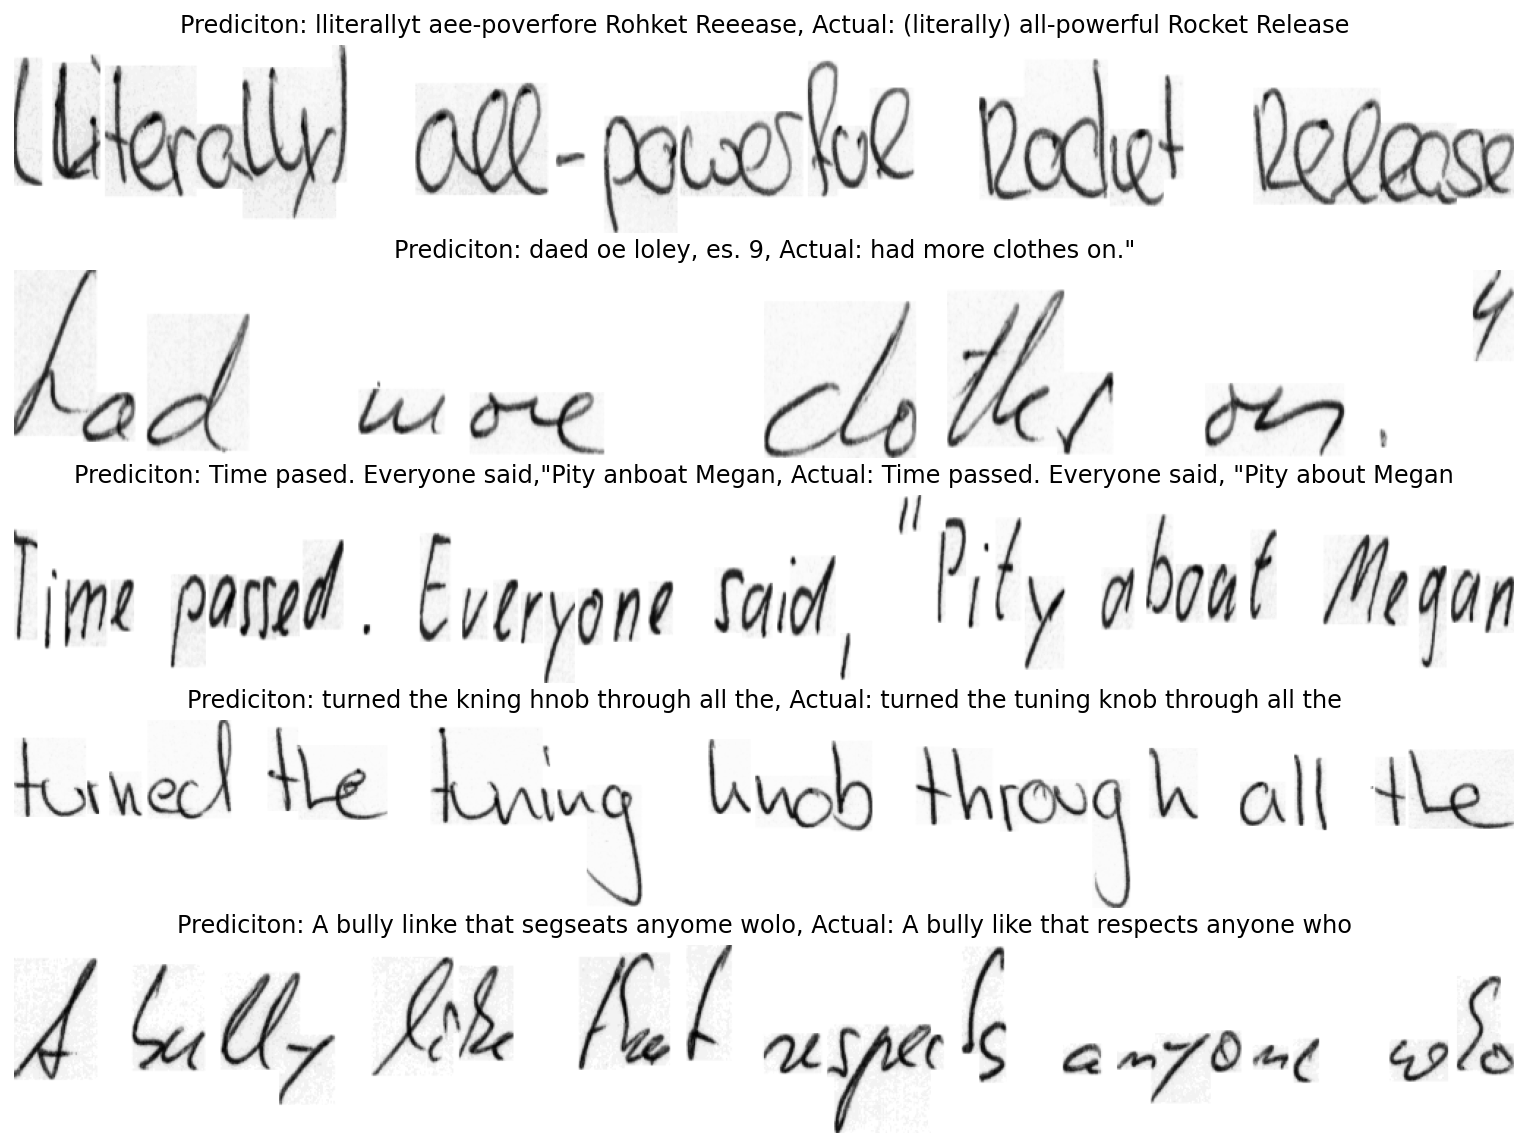

In [38]:
f, axes = plt.subplots(nrows=len(images[:5]), ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images[:5]):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Prediciton: {preds_decoded[i]}, Actual: {ground_truth[i]}")

## Actual images

In [79]:
real_image01 = cv2.imread('images/college.jpg', cv2.IMREAD_GRAYSCALE)
real_image02 = cv2.imread('images/projectname-001.jpg', cv2.IMREAD_GRAYSCALE)
real_image03 = cv2.imread('images/projectname-002.jpg', cv2.IMREAD_GRAYSCALE)
real_image04 = cv2.imread('images/projectname-003.jpg', cv2.IMREAD_GRAYSCALE)

real_images = [real_image01, real_image02, real_image03, real_image04]

In [80]:
transforms = A.Compose([
                A.augmentations.geometric.Resize(
                    height=128, width=1024, p=1.0, always_apply=True),
                transform.Rotate(always_apply=True, p=1.0),
                transform.ToTensor(always_apply=True, p=1.0)
            ])
resized_real_images = []
for image in real_images:
    resized_real_image = transforms(image=image)['image']
    resized_real_images.append(resized_real_image)

In [81]:
dev = 'cpu'

with torch.no_grad():

    model.to(dev)
    images = torch.stack(resized_real_images, dim=0)
    images = images.to(dev)

    preds = model(images)
    preds_decoded = encoder.best_path_decode(
        preds, return_text=True)

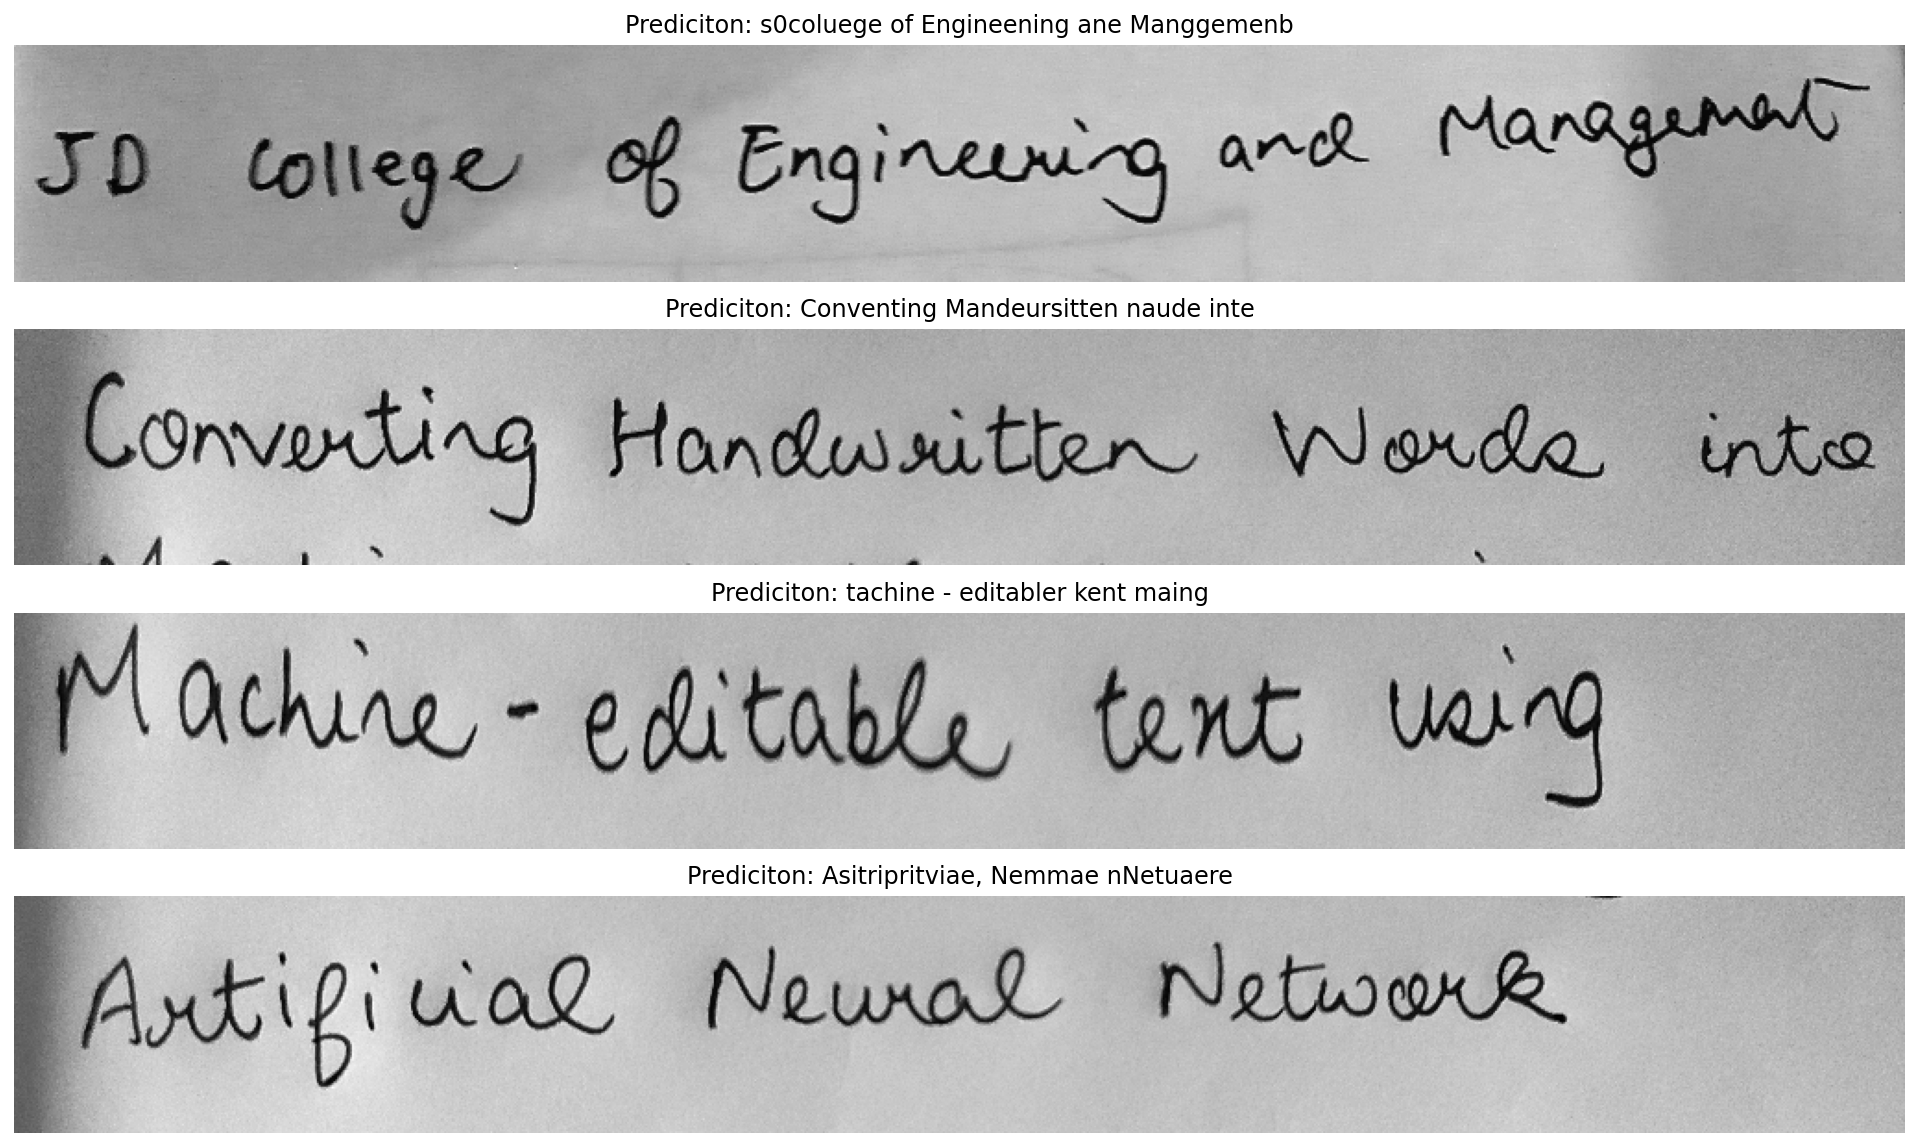

In [84]:
f, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Prediciton: {preds_decoded[i]}")